## Review

Hi Jing! Everything is great now. Thank you fo update. 

---

## Review

Hi Jing. This is Soslan again. I was reviewing your previous project. I've added all my comments to new cells with different coloring.

<div class="alert alert-success" role="alert">
  If you did something great I'm using green color for my comment
</div>

<div class="alert alert-warning" role="alert">
If I want to give you advice or think that something can be improved, then I'll use yellow. This is an optional recommendation.
</div>

<div class="alert alert-danger" role="alert">
  If the topic requires some extra work so I can accept it then the color will be red
</div>

You demonstrate in this project that you have a wide toolset. But there is one thing to fix - you were working with recall metric and by task have to use F1-score. I also write some concerns about using cross-validation with upsampling. It would be also great if you add to your project another technic - downsampling and/or balancing.

---

<div class="alert alert-info" role="alert">
  Hi Soslan, thanks for reviewing my project. I've changed some of the previous code blocks and added new techniques. Thanks for sharing that article about CV and SMOTE, it's really helpful. 
</div>

# Project Instructions
1. Download and prepare the data. Explain the procedure.
2. Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.
3. Improve the quality of the model, taking into account the imbalance of classes. Train different models and find the best one. Briefly describe your findings.
4. Perform the final testing.

# Step 1. Data Preparation
- Import the data 
- Examine missing values
- Feature engineering if needed
- Feature scaling / encoding

In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import itertools
import operator
import warnings
import matplotlib.pyplot as plt

from statistics import mean
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.metrics import precision_score, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import resample, shuffle

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.pandas.set_option('display.max_columns', None)

In [2]:
raw = pd.read_csv('/datasets/Churn.csv')
raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# Right off the bat, we don't need RowNumber, CustomerId, and Surname because they will cause overfitting.
# In other words, we want the model to learn the general principles behind the data not memorize which customer did left 
# as a result.

df = raw.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# Make a list of the variables that contain missing values
# Determine percentage of missing values

vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]
df[vars_with_na].isnull().mean()

Tenure    0.0909
dtype: float64

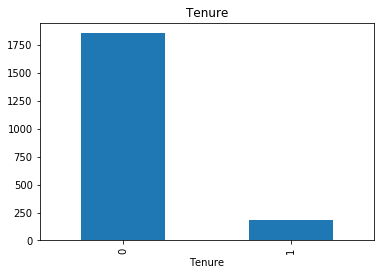

In [5]:
# Before replacing missing values with median or mean, I want to experiment to see if we can just drop these 10% data

temp = df.copy()
temp.Tenure = np.where(temp.Tenure.isnull(), 1, 0)
temp.groupby('Tenure')['Exited'].sum().plot.bar()
plt.title('Tenure')
plt.show()

In [6]:
# So we have about 250 people that churned and their tenure information is missing
# We will go ahead and just filling the missing values with median then

df.Tenure.fillna(df['Tenure'].median(), inplace=True)

In [7]:
# feature engineer the age column

labels = ["{0}-{1}".format(i, i+9) for i in range(0,100,10)]
df.Age = pd.cut(df.Age, range(0,101,10), right=False, labels=labels)
df.Age = df.Age.astype('object')

In [8]:
# for reference

df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                 object
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [9]:
# feature scaling

scaler = StandardScaler()
num_vars = [var for var in df.columns if df[var].dtypes != 'O']
num_vars.remove('Exited')
df[num_vars] = scaler.fit_transform(df[num_vars])

In [10]:
# feature encoding

encoder = OrdinalEncoder() 
cat_vars = [var for var in df.columns if df[var].dtypes == 'O']
df[cat_vars] = encoder.fit_transform(df[cat_vars])

In [11]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.326221,0.0,0.0,3.0,-1.086246,-1.225848,-0.911583,0.646092,0.970243,0.021886,1
1,-0.440036,2.0,0.0,3.0,-1.448581,0.117350,-0.911583,-1.547768,0.970243,0.216534,0
2,-1.536794,0.0,0.0,3.0,1.087768,1.333053,2.527057,0.646092,-1.030670,0.240687,1
3,0.501521,0.0,0.0,2.0,-1.448581,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,0
4,2.063884,2.0,0.0,3.0,-1.086246,0.785728,-0.911583,0.646092,0.970243,-0.365276,0


### Conclusion
- Tenure column has 9% of data that are missing values. Out of these 9%, about 250 positive targets are embeded. Median is used to replace missing values. 
- Age is grouped into bins to help the model better generalize patterns.
- Standard scaler and ordinal encoder are used for feature scaling and categorical encoding.

<div class="alert alert-success" role="alert">
Good start.
</div>

# Step 2. Baseline Performance
In this section, we will examine both Decision Tree, Random Forest, and Gradient Boosting model's baseline performance. Please note the models will use the imbalanced dataset as is. 
- We will try the class_weight option for random forest and decision tree model.

In [12]:
# Stratified train test split / 80-20

train, val = train_test_split(df, test_size=0.20, stratify=df.Exited, random_state=123)
x_train, x_val = train.drop('Exited', axis=1), val.drop('Exited', axis=1)
y_train, y_val = train['Exited'], val['Exited']

In [13]:
# Baseline performance using imbalanced train set - Decision Tree

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123)
tree = cross_validate(DecisionTreeClassifier(), x_train, y_train, scoring=['roc_auc','f1'], cv=cv, n_jobs=-1, 
                      error_score='raise')
print('ROC AUC: %.3f (%.3f)' % (tree['test_roc_auc'].mean(), tree['test_roc_auc'].std()))
print('F1 Score: %.3f (%.3f)' % (tree['test_f1'].mean(), tree['test_f1'].std()))

ROC AUC: 0.680 (0.019)
F1 Score: 0.489 (0.030)


In [14]:
# Decision Tree with class_weight option

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123)
tree = cross_validate(DecisionTreeClassifier(class_weight='balanced'), x_train, y_train, scoring=['roc_auc','f1'], cv=cv, n_jobs=-1, 
                      error_score='raise')
print('ROC AUC: %.3f (%.3f)' % (tree['test_roc_auc'].mean(), tree['test_roc_auc'].std()))
print('F1 Score: %.3f (%.3f)' % (tree['test_f1'].mean(), tree['test_f1'].std()))

ROC AUC: 0.677 (0.020)
F1 Score: 0.485 (0.031)


In [15]:
# Baseline performance using imbalanced train set - Random Forest

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123)
rf = cross_validate(RandomForestClassifier(), x_train, y_train, scoring=['roc_auc','f1'], cv=cv, n_jobs=-1, 
                    error_score='raise')
print('ROC AUC: %.3f (%.3f)' % (rf['test_roc_auc'].mean(), rf['test_roc_auc'].std()))
print('F1 Score: %.3f (%.3f)' % (rf['test_f1'].mean(), rf['test_f1'].std()))

ROC AUC: 0.806 (0.022)
F1 Score: 0.511 (0.039)


In [16]:
# Random Forest with class_weight option

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123)
rf = cross_validate(RandomForestClassifier(class_weight='balanced'), x_train, y_train, scoring=['roc_auc','f1'], cv=cv, n_jobs=-1, 
                    error_score='raise')
print('ROC AUC: %.3f (%.3f)' % (rf['test_roc_auc'].mean(), rf['test_roc_auc'].std()))
print('F1 Score: %.3f (%.3f)' % (rf['test_f1'].mean(), rf['test_f1'].std()))

ROC AUC: 0.806 (0.021)
F1 Score: 0.505 (0.041)


In [17]:
# Baseline performance using imbalanced train set - Gradient Boosting

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123)
gb = cross_validate(GradientBoostingClassifier(), x_train, y_train, scoring=['roc_auc','f1'], cv=cv, n_jobs=-1, 
                    error_score='raise')
print('ROC AUC: %.3f (%.3f)' % (gb['test_roc_auc'].mean(), gb['test_roc_auc'].std()))
print('F1 Score: %.3f (%.3f)' % (gb['test_f1'].mean(), gb['test_f1'].std()))

ROC AUC: 0.857 (0.017)
F1 Score: 0.554 (0.033)


### Conclusion
- When the original imbalanced train set is used, all three models performs somewhat similar to each other. Decision tree has the lowest f1 score. Gradient boosting model has the highest baseline performance in both roc auc and f1.
- It's observed that even with the class_weight option, decision tree model and random forest model's performance did not surpass that of Gradient Boosting.
- Since the Gradient Boosting model yields the best result, we will use f1 score 0.554 as our baseline performance.

# Step 3. Resampling
Based on the previous observation, We will choose Gradient Boosting as the potential final model. All tuning and class balancing will be applied to this model only. In following, we will examine:
- Assess cross validated train results using upsampled train set
- Assess cross validated train results using downsampled train set

In [18]:
# Examine class ratios of the target column

df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [19]:
def class_balance(x, y, perc, option='upsample'):
    """
    resampling function, makes easy to be called in a customized CV function later
    """    
    X = pd.concat([x, y], axis=1)
    neg = X[X.Exited==0]
    pos = X[X.Exited==1]
    
    if option is 'upsample':
        
        pos_upsampled = resample(pos, replace=True, n_samples=np.ceil(len(neg)*perc).astype('int64'), random_state=123) 
        
        df_upsampled = pd.concat([neg, pos_upsampled])
        df_upsampled = shuffle(df_upsampled, random_state=123)
    
        y_train_sampled = df_upsampled.Exited
        x_train_sampled = df_upsampled.drop('Exited', axis=1)
        
    if option is 'downsample':
        
        neg_downsampled = resample(neg, replace = False, n_samples = np.ceil(len(pos)*perc).astype('int64'), random_state = 123)
        
        df_downsampled = pd.concat([neg_downsampled, pos])
        df_downsampled = shuffle(df_downsampled, random_state=123)
        
        y_train_sampled = df_downsampled.Exited
        x_train_sampled = df_downsampled.drop('Exited', axis=1)
    
    return x_train_sampled, y_train_sampled

In [20]:
# Upsampling

x_train_upsampled, y_train_upsampled = class_balance(x_train, y_train, 0.8)
y_train_upsampled.value_counts()

0    6370
1    5096
Name: Exited, dtype: int64

In [21]:
# Downsampling

x_train_downsampled, y_train_downsampled = class_balance(x_train, y_train, 1.2, 'downsample')
y_train_downsampled.value_counts()

0    1956
1    1630
Name: Exited, dtype: int64

In [22]:
# Gradient Boosting performance using upsampled train set

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123)
gb = cross_validate(GradientBoostingClassifier(), x_train_upsampled, y_train_upsampled, scoring=['roc_auc','f1'], cv=cv, 
                    n_jobs=-1, error_score='raise')
print('ROC AUC: %.3f (%.3f)' % (gb['test_roc_auc'].mean(), gb['test_roc_auc'].std()))
print('F1 Score: %.3f (%.3f)' % (gb['test_f1'].mean(), gb['test_f1'].std()))

ROC AUC: 0.874 (0.009)
F1 Score: 0.755 (0.015)


In [23]:
# Gradient Boosting performance using downsampled train set

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123)
gb = cross_validate(GradientBoostingClassifier(), x_train_downsampled, y_train_downsampled, scoring=['roc_auc','f1'], cv=cv, 
                    n_jobs=-1, error_score='raise')
print('ROC AUC: %.3f (%.3f)' % (gb['test_roc_auc'].mean(), gb['test_roc_auc'].std()))
print('F1 Score: %.3f (%.3f)' % (gb['test_f1'].mean(), gb['test_f1'].std()))

ROC AUC: 0.859 (0.014)
F1 Score: 0.749 (0.024)


### Conclusion
- We see that the model performance is better when using the upsampled train set. But please note that these are cross validated train results. To see more realistic results, we need to use these up or downsampled sets to train the model and then use the model to predict on the original valiation set. 
- For the remaining portion of this project, I will try to incorporate upsampling with cross validation. The reason that I choose upsampling is that downsampled data depth is significantly shallower than the original data set, thus we would risk losing information that could benefit the model while training.

<div class="alert alert-warning" role="alert">
As you correctly notice you didn't upsample the validation set. But when you use cross-validation with upsampling the validation set inside CV is also balanced. And that could be theoretically a problem especially when you use RandomizedSearchCV and make decisions about the best parameters. So I think it is better to use some custom CV or even try the classical "train-validation-test" approach.
</div>

Here an intersting article about how to use CV with upsampling: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

---

# Step 4. Model Optimization
The goal of this section is to optimize the Gradient Boosting model using upsampled train set. Then, we will visualize how recall and precision respond to various threshold setting.
- Incorporate randomized grid search into CV
- Examine various probability threshold setting

In [24]:
params = {'learning_rate':[0.5,0.3,0.2,0.1,0.095,0.085,0.055,0.045,0.035,0.025,0.05], 
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 500],
          'max_depth':[3,5,7,9,11,13,15], 
          'min_samples_split':[2,4,6,8,10,12,14,16,20,40,60], 
          'min_samples_leaf':[1,3,5,7,9,11],
          'subsample':[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
         }

In [26]:
# Customized RandomizedSearchCV

def classifier_cv_with_sampling(model, params, n_iters, folds, scoring, option="upsample"):
    """
    Creates folds manually, and upsamples or downsamples within each fold.
    Returns an array of validation scores
    """
    results = {}
    scores = []
    cv = RepeatedStratifiedKFold(n_splits=folds, n_repeats=2, random_state=123)
    
    keys, values = zip(*params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    experiments = shuffle(experiments, random_state=123)
    
    for i in range(n_iters):    
        
        for train_fold_index, val_fold_index in cv.split(x_train, y_train):

            x_train_fold, y_train_fold = x_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
            x_val_fold, y_val_fold = x_train.iloc[val_fold_index], y_train.iloc[val_fold_index]

            if option is "upsample":
                x_train_sampled, y_train_sampled = class_balance(x_train_fold, y_train_fold, 0.8)

            if option is "downsample":
                x_train_sampled, y_train_sampled = class_balance(x_train_fold, y_train_fold, 1.2, 'downsample')

            model_obj = model(**experiments[i], validation_fraction=0.1, n_iter_no_change=20).fit(x_train_sampled, y_train_sampled)
            temp = scoring(y_val_fold, model_obj.predict(x_val_fold))
            scores.append(temp)
                        
        results['test_%s' % scoring.__name__] = np.mean(np.array(scores).reshape(-1, folds*2), axis=1)
        index, value = max(enumerate(results['test_%s' % scoring.__name__]), key=operator.itemgetter(1))
        results['best_%s' % scoring.__name__] = value
        results['best_params'] = experiments[index]
    
    return results

In [27]:
results = classifier_cv_with_sampling(GradientBoostingClassifier, params, 30, 3, f1_score, 'upsample')
results

{'test_f1_score': array([0.5922208 , 0.60201856, 0.60231709, 0.55678625, 0.58043765,
        0.59953826, 0.56943355, 0.60321509, 0.54401098, 0.55322087,
        0.59601494, 0.5950525 , 0.6008611 , 0.55821038, 0.60089328,
        0.60389686, 0.60028312, 0.55936801, 0.56217809, 0.56658413,
        0.59008914, 0.5932987 , 0.5626713 , 0.58527589, 0.56380886,
        0.59801696, 0.55843418, 0.60391687, 0.57602537, 0.543821  ]),
 'best_f1_score': 0.6039168697622479,
 'best_params': {'learning_rate': 0.025,
  'n_estimators': 250,
  'max_depth': 7,
  'min_samples_split': 10,
  'min_samples_leaf': 7,
  'subsample': 0.55}}

In [28]:
# visualize recall vs. precision trend at various probability threshold settings.

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

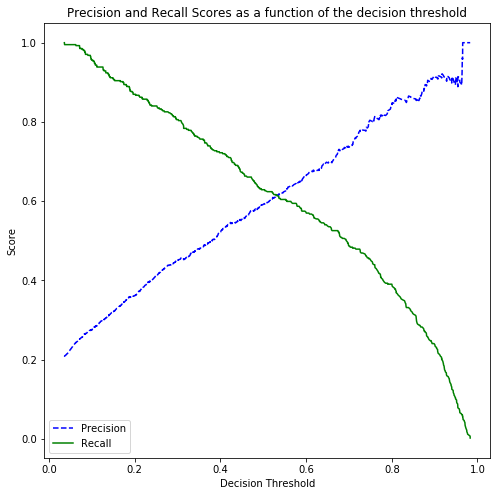

In [29]:
gb = GradientBoostingClassifier(**results['best_params'], validation_fraction=0.1, 
                                n_iter_no_change=20).fit(x_train_upsampled, y_train_upsampled)
y_prob = gb.predict_proba(x_val)[:, 1]
p, r, thresholds = precision_recall_curve(y_val, y_prob)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [31]:
y_pred = gb.predict(x_val)
print('ROC AUC (0.5 threshold): %.3f' % (roc_auc_score(y_val, y_pred)))
print('F1 Score (0.5 threshold): %.3f' % (f1_score(y_val, y_pred)), '\n')

y_pred_adjusted = (y_prob > 0.56).astype(bool)
print('ROC AUC (0.56 threshold): %.3f' % (roc_auc_score(y_val, y_pred_adjusted)))
print('F1 Score (0.56 threshold): %.3f' % (f1_score(y_val, y_pred_adjusted)))

ROC AUC (0.5 threshold): 0.759
F1 Score (0.5 threshold): 0.610 

ROC AUC (0.56 threshold): 0.756
F1 Score (0.56 threshold): 0.618


### Conclusion
- The cross validated test f1 score is 0.61 which is better than our baseline score 0.554.
- It is observed that the optimal probability threshold is actually 0.5. This proves that the upsampling technique appears to be working in the CV and random search process. The model was able to learn from those oversampled instances and made similar decision on the valiation set. Even though the validation set is not resampled, the model performs well using the default threshold.

# Step 5. Model Refitting and Performance Assessing

In [32]:
# Confusion matrix plot

def plot_confusion_matrix(cm, classes, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

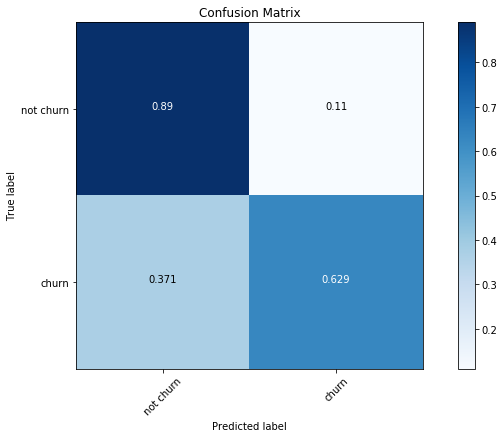

In [33]:
cfm = confusion_matrix(y_val, y_pred, labels=[0, 1])
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["not churn", "churn"], normalize=True)

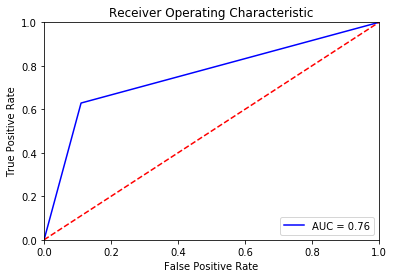

In [34]:
# calculate the fpr and tpr for all thresholds of the classification

probs = gb.predict_proba(x_val)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Conclusion
- We are able to increase 0.05 on f1 score after incorporate the resampling and randomsearch together. This sure is a good exercise for me. Thank you for the help and time to review my project.